In [1]:
%cd ../..
%pwd
"""
pip install --upgrade nltk
"""

import json
from pathlib import Path
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer

RNG = np.random.default_rng(42)
EMBED_MODEL  = SentenceTransformer("all-mpnet-base-v2")

/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/root/CoTFaithChecker


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def load_annotation_json(path: Path, label: str) -> pd.DataFrame:
    """Return one row per (question_id, sentence_id, category, weight)."""
    rows = []
    with path.open() as f:
        blob = json.load(f)

    for q in blob:
        qid = q["question_id"]
        for sent in q["annotations"]:
            sid = sent["sentence_id"]
            for cat, val in sent.items():
                if cat in {"sentence_id", "other_label"} or cat == "other":
                    continue
                if isinstance(val, (int, float)) and val > 0:
                    rows.append(
                        dict(question_id=qid,
                             sentence_id=sid,
                             category=cat,
                             weight=val,
                             condition=label)
                    )
    return pd.DataFrame(rows)

def load_full_text(path: Path, label: str) -> pd.DataFrame:
    """Return one row per (question_id, sentence_id, text)."""
    rows = []
    with path.open() as f:
        blob = json.load(f)

    for q in blob:
        qid  = q["question_id"]
        # split on explicit newline–newline boundary that MMLU completions use
        # keeps "Answer: D" line as its own sentence
        sentences = [s.strip() for s in q["completion"].split("\n") if s.strip()]
        for sid, text in enumerate(sentences, start=1):
            rows.append(
                dict(question_id=qid,
                     sentence_id=sid,
                     text=text,
                     condition=label)
            )
    return pd.DataFrame(rows)


import re
from pathlib import Path

root = Path("c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B")

_answer_re = re.compile(r"\*\*Answer:\*\*", flags=re.I)
# split on ., ?, ! followed by whitespace + uppercase / digit / quote / bullet
_sent_split_re = re.compile(r"(?<=[.!?])\s+(?=[0-9A-Z\"'(\[])")

In [3]:
def split_into_sentences(text: str) -> list[str]:
    #Answer is present: keep everything after it as one sentence;
    #Otherwise, split on punctuation boundary regex above;
    #Strip whitespace and remove empty segments.
    if _answer_re.search(text):
        reasoning, answer = _answer_re.split(text, maxsplit=1)
        reasoning_sents = [s.strip() for s in _sent_split_re.split(reasoning.replace("\n", " ")) if s.strip()]
        answer_sent = f"**Answer:** {answer.strip()}"
        return reasoning_sents + [answer_sent]
    else:
        return [s.strip() for s in _sent_split_re.split(text.replace("\n", " ")) if s.strip()]


def load_full_text(path: Path, label: str) -> pd.DataFrame:
    """Return one row per (question_id, sentence_id, text)."""
    rows = []
    with path.open() as f:
        blob = json.load(f)

    for q in blob:
        qid = q["question_id"]
        for sid, sent in enumerate(split_into_sentences(q["completion"]), start=1):
            rows.append(
                dict(question_id=qid,
                     sentence_id=sid,
                     text=sent,
                     condition=label)
            )
    return pd.DataFrame(rows)


df_ann_no = load_annotation_json(root / "filtered_60_verbalized_annotations_confidence_none.json",
                                 "no_hint")
df_ann_hi = load_annotation_json(root / "filtered_60_verbalized_annotations_confidence_sycophancy.json",
                                 "hint")
df_ann = pd.concat([df_ann_no, df_ann_hi], ignore_index=True)

df_txt_no = load_full_text(root / "completions/none.json",        "no_hint")
df_txt_hi = load_full_text(root / "completions/sycophancy.json",  "hint")
df_txt = pd.concat([df_txt_no, df_txt_hi], ignore_index=True)

df = df_ann.merge(df_txt,
                  on=["question_id", "sentence_id", "condition"],
                  how="left",
                  validate="many_to_one")

missing = df["text"].isna().sum()
if missing:
    print(f"!{missing} annotation rows lacked matching sentence text "
          "and were dropped from analysis.")
    df = df.dropna(subset=["text"])

cats = sorted(df["category"].unique())

pivot = (df.groupby(["condition", "category"]).size()
           .unstack(fill_value=0)
           .loc[["no_hint", "hint"]])

chi2, p, dof, _ = chi2_contingency(pivot.values)
print(f"Chi² = {chi2:.2f},  p = {p:.3g},  dof = {dof}")

!3879 annotation rows lacked matching sentence text and were dropped from analysis.
Chi² = 37.24,  p = 5.13e-05,  dof = 10


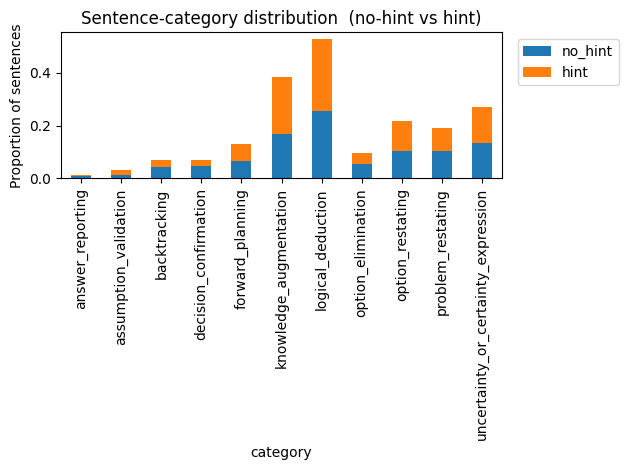

In [4]:
props = pivot.div(pivot.sum(axis=1), axis=0)
fig, ax = plt.subplots()
props.T.plot(kind="bar", stacked=True, ax=ax)
ax.set_title("Sentence-category distribution  (no-hint vs hint)")
ax.set_ylabel("Proportion of sentences")
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()


Share of sentences that are 'knowledge_augmentation':
condition
hint       0.213509
no_hint    0.169092
dtype: float64


Batches: 100%|██████████| 32/32 [00:16<00:00,  1.97it/s]


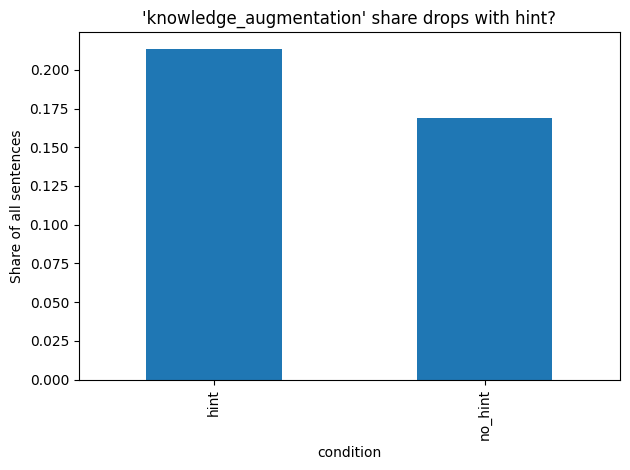

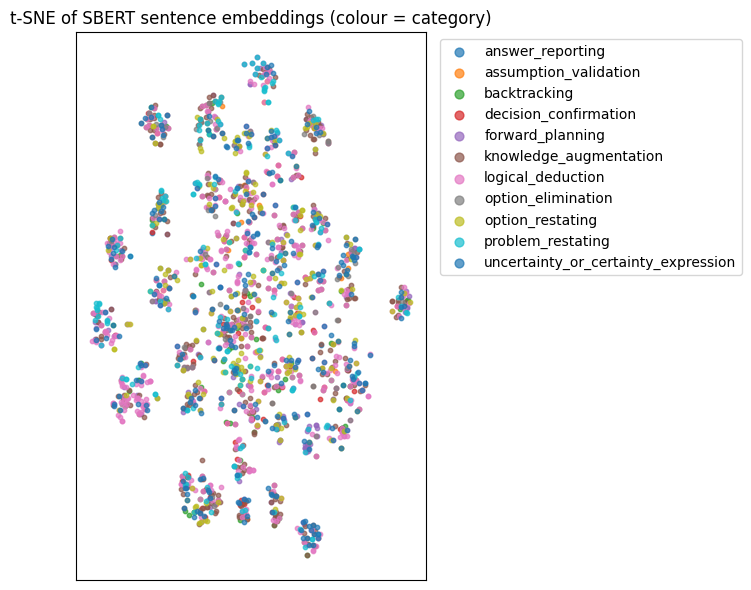

In [5]:
ka_counts    = df[df["category"] == "knowledge_augmentation"].groupby("condition").size()
total_counts = df.groupby("condition").size()
share = ka_counts / total_counts
print("\nShare of sentences that are 'knowledge_augmentation':")
print(share)

fig, ax = plt.subplots()
share.plot(kind="bar", ax=ax)
ax.set_ylabel("Share of all sentences")
ax.set_title("'knowledge_augmentation' share drops with hint?")
plt.tight_layout()

SAMPLE_SIZE = min(2_000, len(df))
sample_df   = df.sample(SAMPLE_SIZE, random_state=42)

sent_texts  = sample_df["text"].tolist()
embeddings  = EMBED_MODEL.encode(sent_texts, batch_size=64, show_progress_bar=True)

tsne  = TSNE(n_components=2, perplexity=30, random_state=42, init="random")
coords = tsne.fit_transform(embeddings)

viz_df = sample_df.reset_index(drop=True).assign(x=coords[:, 0], y=coords[:, 1])

fig, ax = plt.subplots(figsize=(7, 6))
for cat in cats:
    sub = viz_df[viz_df["category"] == cat]
    ax.scatter(sub["x"], sub["y"], s=10, alpha=0.7, label=cat)
ax.set_title("t-SNE of SBERT sentence embeddings (colour = category)")
ax.set_xticks([]); ax.set_yticks([])
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", markerscale=2)
plt.tight_layout()


Silhouette score across 11 categories = -0.022

Euclidean shift of mean embedding for 'answer_reporting': 0.680


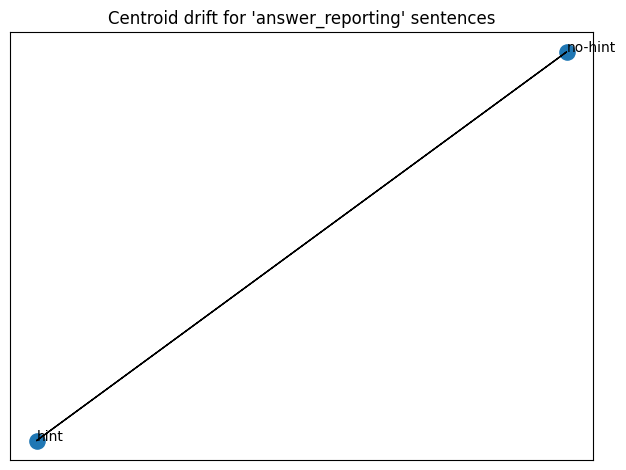

In [6]:
sil = silhouette_score(embeddings, sample_df["category"])
print(f"\nSilhouette score across {len(cats)} categories = {sil:.3f}")

target_cat = "answer_reporting" 

rows_target = df[df["category"] == target_cat].copy()
emb_target  = EMBED_MODEL.encode(rows_target["text"].tolist(),
                                 batch_size=64, show_progress_bar=False)

centroids = {}
for cond in ["no_hint", "hint"]:
    mask = rows_target["condition"] == cond
    centroids[cond] = emb_target[mask].mean(axis=0)

shift = np.linalg.norm(centroids["hint"] - centroids["no_hint"])
print(f"\nEuclidean shift of mean embedding for '{target_cat}': {shift:.3f}")

centroid_mat = np.vstack([centroids["no_hint"], centroids["hint"]])
tsne_cent    = TSNE(n_components=2, perplexity=1, random_state=42, init="random")
coords_cent  = tsne_cent.fit_transform(centroid_mat)

fig, ax = plt.subplots()
ax.scatter(coords_cent[:, 0], coords_cent[:, 1], s=120)
ax.annotate("no-hint", coords_cent[0])
ax.annotate("hint",    coords_cent[1])
ax.arrow(coords_cent[0, 0], coords_cent[0, 1],
         coords_cent[1, 0] - coords_cent[0, 0],
         coords_cent[1, 1] - coords_cent[0, 1],
         length_includes_head=True, head_width=0.8)
ax.set_title(f"Centroid drift for '{target_cat}' sentences")
ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()

In [7]:

np.save("embeddings_sbert_sample.npy", embeddings)
pivot.to_csv("c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/prev/category_counts.csv")

Batches: 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Silhouette after cleaning + UMAP: -0.170


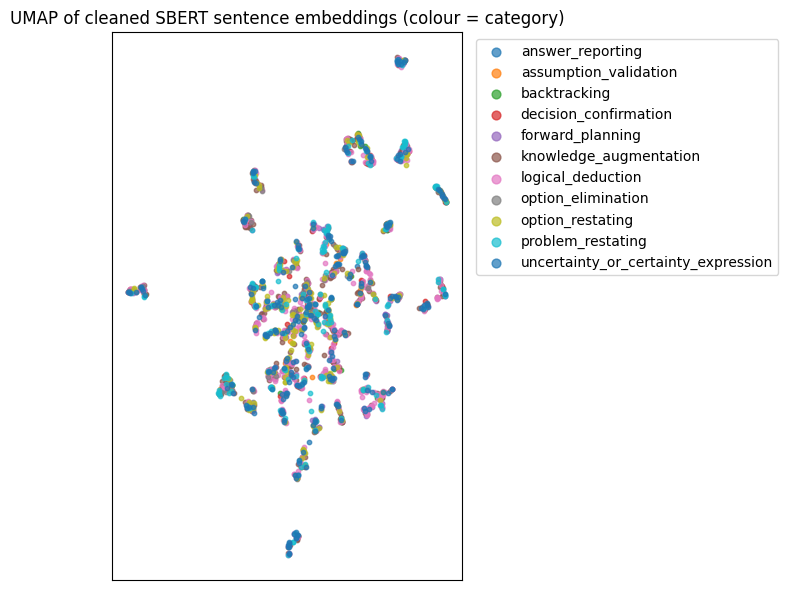

In [8]:
import re
from sklearn.decomposition import PCA
from umap import UMAP

_prompt_re = re.compile(r"^(Let'?s|Let's)\s+think.*?step by step[.:]?\s*", flags=re.I)

def clean(text: str) -> str:
    return _prompt_re.sub("", text).strip()

SAMPLE_SIZE = min(2_000, len(df))
sample_df   = df.sample(SAMPLE_SIZE, random_state=42)

sent_texts  = [clean(t) for t in sample_df["text"]]
embeddings  = EMBED_MODEL.encode(sent_texts, batch_size=64, show_progress_bar=True)

pca = PCA(n_components=50, random_state=42)
embeddings_50d = pca.fit_transform(embeddings)

umap = UMAP(n_neighbors=15,
            min_dist=0.3,           # how tight clusters can get
            metric="cosine",
            random_state=42)
coords = umap.fit_transform(embeddings_50d)

# 4️⃣  Plot
viz_df = sample_df.reset_index(drop=True).assign(x=coords[:,0], y=coords[:,1])

fig, ax = plt.subplots(figsize=(7,6))
for cat in cats:
    sub = viz_df[viz_df["category"] == cat]
    ax.scatter(sub["x"], sub["y"], s=10, alpha=0.7, label=cat)
ax.set_title("UMAP of cleaned SBERT sentence embeddings (colour = category)")
ax.set_xticks([]); ax.set_yticks([])
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", markerscale=2)
plt.tight_layout()

# silhouette score (still valid with UMAP coords)
from sklearn.metrics import silhouette_score
sil = silhouette_score(coords, sample_df["category"])
print(f"Silhouette after cleaning + UMAP: {sil:.3f}")


In [10]:
import json, re
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from umap import UMAP
from sentence_transformers import SentenceTransformer
from sklearn.metrics import silhouette_score

EMBED_MODEL = SentenceTransformer("all-mpnet-base-v2")

sent_file = Path("c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/filtered_71_unverbalized_annotations_confidence_none.json")
with sent_file.open() as f:
    blob = json.load(f)

rows = []
for q in blob:
    qid = q["question_id"]
    for sent in q["annotations"]:
        sid = sent["sentence_id"]
        # recover the single category that has weight > 0 (ties are rare)
        cat  = max(
            (k for k in sent if k not in {"sentence_id", "other_label"}),
            key=lambda k: sent[k]
        )
        rows.append(
            dict(question_id=qid,
                 sentence_id=sid,
                 category=cat,
                 text=sent.get("text", ""))         # some dumps include it
        )

df = pd.DataFrame(rows)
assert (df["text"] != "").any(), "No sentence text found – check your JSON!"

cats = sorted(df["category"].unique())

_prompt_re = re.compile(r"^(Let'?s|Let's)\s+think.*?step by step[.:]?\s*", flags=re.I)
df["clean_text"] = df["text"].str.replace("\n", " ").str.strip()
df["clean_text"] = df["clean_text"].apply(lambda t: _prompt_re.sub("", t))

embeddings = EMBED_MODEL.encode(df["clean_text"].tolist(),
                                batch_size=64, show_progress_bar=True)

pca  = PCA(n_components=50, random_state=42)
x50  = pca.fit_transform(embeddings)

umap = UMAP(n_neighbors=15, min_dist=0.3, metric="cosine", random_state=42)
coords = umap.fit_transform(x50)
df["x"], df["y"] = coords[:,0], coords[:,1]

fig, ax = plt.subplots(figsize=(7,6))
for cat in cats:
    sub = df[df["category"] == cat]
    ax.scatter(sub["x"], sub["y"], s=10, alpha=0.7, label=cat)
ax.set_title("UMAP of cleaned SBERT sentence embeddings (colour = category)")
ax.set_xticks([]); ax.set_yticks([])
ax.legend(bbox_to_anchor=(1.02,1), loc="upper left", markerscale=2)
plt.tight_layout()

sil = silhouette_score(coords, df["category"])
print(f"Silhouette score (UMAP space): {sil:.3f}")



AssertionError: No sentence text found – check your JSON!